<h1><center>SpaCAE Tutorial</center></h1>


### Outline
Tutorial 1: 10x Visium (DLPFC dataset)<br>
Tutorial 2: ST data (HER2-positive breast cancer)<br>

### Tutorial 1: 10x Visium (DLPFC dataset)
Here, we reapply SpaCAE onto the 151675 slice of human dorsolateral prefrontal cortex (DLPFC) to demonstrates the identification of spatial domains on 10x Visium data. 
The human dorsolateral prefrontal cortex (DLPFC) datasets are available in the spatialLIBD package at http://spatial.libd.org/spatialLIBD. To run SpaCAE analysis, we first download `model.py`, `utils.py`, and `SpaCAE.py` from https://github.com/HYF01/SpaCAE/tree/main/SpaCAE.

1. Import python modules

In [1]:
import os
import scanpy as sc
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [2]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'E:\\R\\R-4.2.2'
os.environ['R_USER'] = 'E:\\environment2023\\Anaconda3\\envs\\ae38\\Lib\\site-packages\\rpy2'

  2. Read in data

In [3]:
myadata = sc.read_visium('151675')
myadata.var_names_make_unique()
sc.pp.highly_variable_genes(myadata, n_top_genes=2000, flavor='seurat_v3')

E:\environment2023\Anaconda3\envs\stlearn\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
myadata

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

  3. Load SpaCAE model

In [5]:
from SpaCAE import SpaCAE

In [6]:
myspacae = SpaCAE(adata=myadata, num_cluster=7)

  4. Expression matrix standardization and data augmentation<br>
  `stg` is the constructed spot adjacency graph, `oridata` and `augdata` are the original gene expression matrix and augmented gene expression matrix respectively.

In [7]:
n_adata, oridata, augdata, stg = myspacae.load_data()

1/3.Starting loading data...
The data was successfully loaded and the graph constructed


In [8]:
n_adata

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'pca', 'spatial_reconstruction'
    obsm: 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log1p-ori', 'log1p-aug'

  5. Model training <br>
  `z_ori` and `z_aug` are latent representations used to identify spatial domains.

In [9]:
z_ori, z_aug, xhat_ori, xhat_aug = myspacae.train_SpaCAE(oridata, augdata, stg)

2/3.Starting training...


loss=8.171182632446289: 100%|███████████████████████████████████████████████████| 40000/40000 [02:14<00:00, 297.52it/s]


Successful completion of training


  6. Identify spatial domains using Mclust algorithms.<br>

In [10]:
c_adata = myspacae.cluster(n_adata, z_ori)

3/3.Starting clusting...


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [11]:
c_adata.obs['spacae_clust']

AAACAACGAATAGTTC-1    1
AAACAAGTATCTCCCA-1    5
AAACACCAATAACTGC-1    3
AAACAGAGCGACTCCT-1    2
AAACAGGGTCTATATT-1    4
                     ..
TTGTTGTGTGTCAAGA-1    7
TTGTTTCACATCCAGG-1    3
TTGTTTCATTAGTCTA-1    3
TTGTTTCCATACAACT-1    4
TTGTTTGTATTACACG-1    3
Name: spacae_clust, Length: 3592, dtype: category
Categories (7, object): ['1', '2', '3', '4', '5', '6', '7']

  7. Spatial domain visualization.<br>

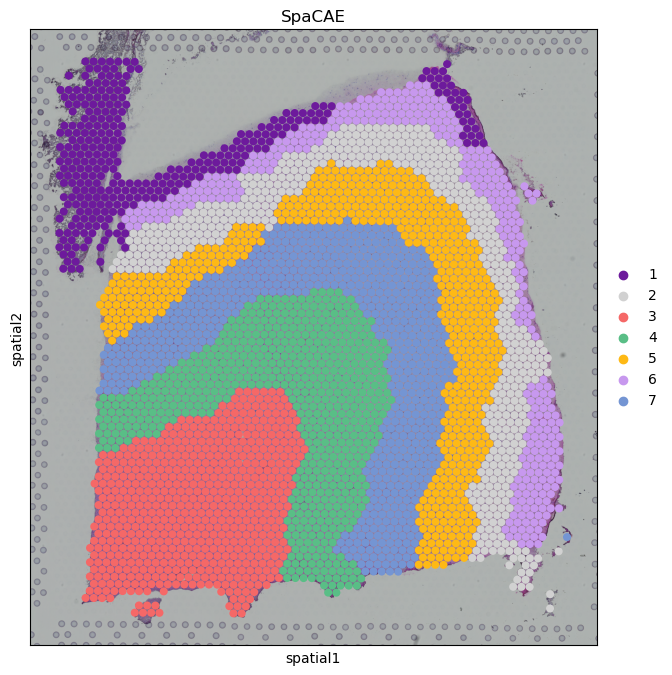

In [12]:
myspacae.plot_domain(c_adata)

In [13]:
# read the annotation
GT_meta = pd.read_csv('151675/metadata.tsv', sep='\t')
GT_meta['SpaCAE'] = c_adata.obs["spacae_clust"].tolist()
GT_meta = GT_meta[~pd.isnull(GT_meta['layer_guess'])]
ARI = adjusted_rand_score(GT_meta['layer_guess'], GT_meta['SpaCAE'])
NMI = normalized_mutual_info_score(GT_meta['layer_guess'], GT_meta['SpaCAE'])

In [14]:
ARI,NMI

(0.6862745935442799, 0.7571973396616536)

### Tutorial 2: ST data (HER2-positive breast cancer)
We demonstrate the capacity of SpaCAE on cancer tissue. 
The HER2-positive breast tumor data from ST platform is available at https://github.com/almaan/her2st.

1. Import python modules

In [1]:
import os
import scanpy as sc
import pandas as pd
import stlearn as st
import numpy as np

In [2]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'E:\\R\\R-4.2.2'
os.environ['R_USER'] = 'E:\\environment2023\\Anaconda3\\envs\\ae38\\Lib\\site-packages\\rpy2'

  2. Read in data

In [3]:
h2adata = st.ReadOldST(count_matrix_file="H1/H1.tsv/ut_H1_stdata_filtered.tsv",
                     spatial_file="H1/H1_selection.tsv/H1_selection.tsv",
                     image_file="H1/H1.jpg")
h2adata.var_names_make_unique()
sc.pp.highly_variable_genes(h2adata, n_top_genes=2000, flavor='seurat_v3')

Added tissue image to the object!


In [4]:
h2adata

AnnData object with n_obs × n_vars = 613 × 14602
    obs: 'imagecol', 'imagerow'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

  3. Load SpaCAE model

In [5]:
from SpaCAE import SpaCAE

In [6]:
h2spacae = SpaCAE(adata=h2adata,
                  num_cluster=7,
                  input_dim=13,  
                  z_dim=13,
                  output_dim=13,
                  alpha=0.1,
                  n_epochs=10000,
                  )

  4. Expression matrix standardization and data augmentation<br>
  `stg` is the constructed spot adjacency graph, `oridata` and `augdata` are the original gene expression matrix and augmented gene expression matrix respectively.

In [7]:
n_adata, oridata, augdata, stg = h2spacae.load_data()

1/3.Starting loading data...
The data was successfully loaded and the graph constructed


In [8]:
n_adata

AnnData object with n_obs × n_vars = 613 × 14602
    obs: 'imagecol', 'imagerow'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'pca', 'spatial_reconstruction'
    obsm: 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log1p-ori', 'log1p-aug'

  5. Model training<br>
  `stg` is the constructed spot adjacency graph, `oridata` and `augdata` are the original gene expression matrix and augmented gene expression matrix respectively.

In [9]:
z_ori, z_aug, xhat_ori, xhat_aug = h2spacae.train_SpaCAE(oridata, augdata, stg)

2/3.Starting training...


loss=1.9115179777145386: 100%|██████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.10it/s]


Successful completion of training


  6. Identify spatial domains using Mclust algorithms.<br>

In [10]:
c_adata = h2spacae.cluster(n_adata, z_ori)

3/3.Starting clusting...


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [11]:
c_adata.obs['spacae_clust']

10x10    1
10x11    1
10x12    1
10x13    1
10x14    1
        ..
9x29     2
9x30     2
9x31     2
9x32     2
9x33     2
Name: spacae_clust, Length: 613, dtype: category
Categories (7, object): ['1', '2', '3', '4', '5', '6', '7']

  7. Spatial domain visualization and the calculation of purity.<br>

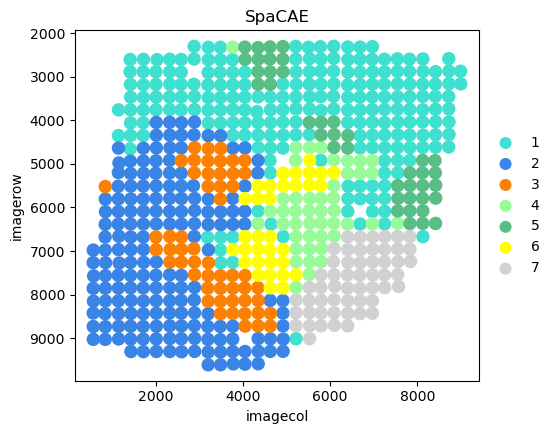

In [12]:
allcolour = ["#40E0D0","#3A84E6","#FC8002","#98FB98","#59BE86", "#FFFF00", "#D1D1D1"]
ax = sc.pl.scatter(n_adata,
                   alpha=1,
                   x="imagecol",
                   y="imagerow",
                   color='spacae_clust',
                   title='SpaCAE',
                   palette=allcolour,
                   show=False,
                   size=230000 / n_adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

In [13]:
from utils import purity_func

spacae_frame = pd.DataFrame(columns=['spacae', 'imagecol', 'imagerow'])
spacae_frame['spacae'] = n_adata.obs['spacae_clust']
spacae_frame['imagerow'] = n_adata.obs['imagerow']
spacae_frame['imagecol'] = n_adata.obs['imagecol']
spacae_frame.index = range(613)
loc_meta = pd.read_csv('H1/H1_selection.tsv/H1_selection.tsv', sep='\t').iloc[:, 2:6]
loc_meta = loc_meta.rename(columns={"pixel_x": "imagecol", "pixel_y": "imagerow"})
spacae_loc = spacae_frame.merge(loc_meta[['imagerow', 'imagecol', 'new_x', 'new_y']])
spacae_loc = spacae_loc.rename(columns={"new_x": "x", "new_y": "y"})
df_meta = pd.read_csv('H1/H1_labeled_coordinates.tsv', sep='\t')
res = spacae_loc.merge(df_meta[['x', 'y', 'label']])

purity = purity_func(res['spacae'], res['label'])

In [14]:
purity

0.6476345840130505